# Neural Networks on MNIST

I will work on the MNIST Dataset by using k-fold Cross Validation.
The project is based on a tutorial about k-fold validation (https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/). 
The ground structure was taken and adapted by me for the usecase of my project.  

### LET'S START!
The aim is to train the model to a minimum accuracy of 0.985 and to explain, why the trained model is bad on predicting specific samples.
For Comfort reasons, the user should not have to carry out each part of the code little by little. Therefore every step is written in a different function, so the user just has to exevute the run function. 

In [105]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from IPython.display import display, clear_output
import time
import math
import datetime
import os
import importlib
import h5py

from matplotlib import pyplot as plt

from numpy import argmax
from numpy import array

import sklearn
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.models import load_model

### Data Analysis
Before we start working with the data, I want to take a look at the data samples itselves. Where could the risk for misrecognizable digits be very high? An example:

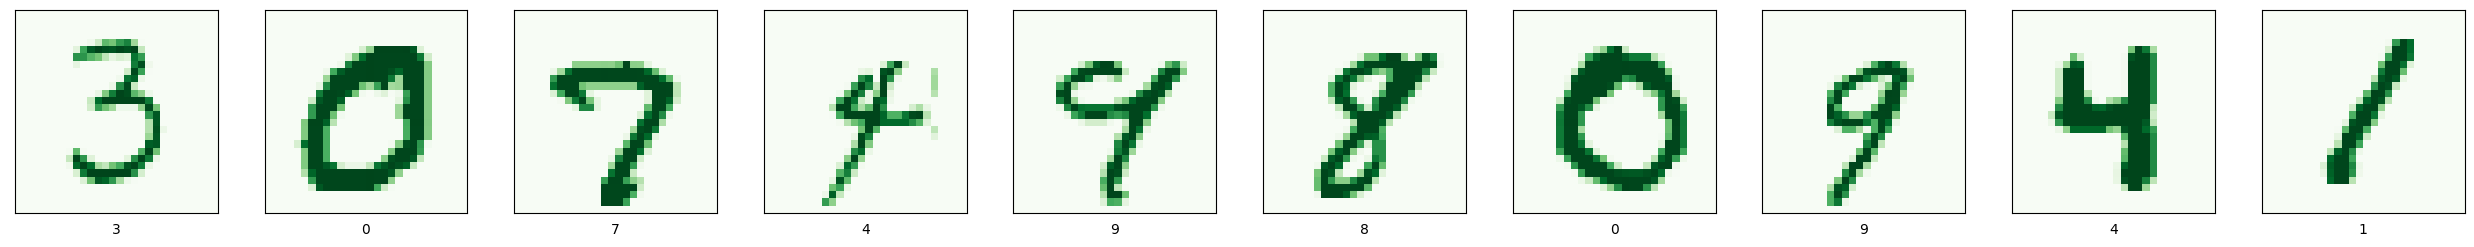

In [106]:
# loading dataset just for teh digit examples
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

# plotting digit examples
numbers_to_display = 10
start_to_display = 50
spot = 0
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(25, 5))
for i in range(start_to_display, start_to_display + numbers_to_display):
 spot += 1
 plt.subplot(1, 10, spot)
 plt.xlabel(trainY[i])
 plt.tight_layout() # pad=5.0 kann z.B. eingefügt werden
 plt.xticks([])
 plt.yticks([])
 plt.grid(True)
 plt.imshow(trainX[i], cmap=plt.get_cmap('Greens'))
#plt.subplots_adjust(hspace=5, wspace=1)
plt.show()

As can be seen in the output, some randomly selected samples are very thin (first '4'), thick (second '4') or poorly drawn (first '9'). I would like to find out if there is a correlation between the way of drawing and the correct recognition of the model.
For that my idea was to plot false predicted images, to visualize why the model could not predict them right. Then I will judge about the reason and whether it is a learning problem or just a bad written digit. More about this later...

### Data Analysis. Defining model
First of all, we have to get through the nasty staff.
The data loading and preparation is taken from my source as it gets me quickly to the actual part of my project. I only added and returned one additional variable that I will use later for plotting my data. 
Furthermore the model will be defined. After using the recommended model from my source for some experimentation, I took some adjustments, as I had some overfitting problems. The learning rate turned out to be too high, so after some comparisons I settled it on 0.005. On top of that, the add of a dropout layer should reduce the chance of overfitting.

In [110]:
def load_dataset():
 (trainX, trainY), (testX, testY) = mnist.load_data()
 testY_ = testY                                                     #to be used in the plotting function
 trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
 testX = testX.reshape((testX.shape[0], 28, 28, 1))
 # categorize to values from 0 to 9
 trainY = to_categorical(trainY)
 testY = to_categorical(testY)
 #return data
 return trainX, trainY, testX, testY, testY_


def prep_pixels(train, test):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 # return normalized images
 return train_norm, test_norm

In [111]:
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(10, activation='softmax'))
 layer = tf.keras.layers.Dropout(.2, input_shape=(2,))
 opt = SGD(learning_rate=0.005, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

### Model evaluation
The main part of the training model is the evaluation. As mentioned at the beginning, k-fold Cross Validation is used to estimate the skill of the trained model. My expactations on this were to increase my accuracy of the model and to uncover possible overfitting.
After few experimentations to configure k, 5 was the best to use in the actual model. Each fold is trained and tested seperately with 6 epoches and a batchsize of 16. The values were chosen based on knowledge from the lessons, limited by the runtime of my laptop.
At first I wanted to write the evaluation of the model (like in my source) in a function, too,  which went well. Later I will implement the plotting function that requires the evaluation to be written directly into the execution function. For this reason the following evaluation function is commented out.

In [109]:
# def evaluate_model(dataX, dataY, n_folds=5):
# 	scores, histories = list(), list()
# 	# preparing cross validation
# 	kfold = KFold(n_folds, shuffle=True, random_state=1)
# 	fold_counter = 1
# 	# enumerate splits
# 	for train_ix, test_ix in kfold.split(dataX):
# 		fold_counter += 1

# 		# define model
# 		model = define_model()
# 		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
# 		history = model.fit(trainX, 
# 							trainY, 
# 							epochs=8, 
# 							batch_size=10, 
# 							validation_data=(testX, testY))
# 		# evaluate model
# 		acc = model.evaluate(testX, testY)

# 		# model scores
# 		scores.append(acc)
# 		histories.append(history)
# 	print("workout finished")
# 	return scores, histories

### Visualization
For me, the visualization of the model's performance is important to assess his abilities to recognize digits. 
I implemented the following function to graphicaly describe my model and to make decissions about possible adjustments such as decreasing the learning rate. If my validation loss will decrease, the learning rate was way to high and the model starts to learn the training samples from memory. Both, entropy loss and classification accurance, were plotted for each fold. The developement of the training set and the validation set will be visible. 

In [76]:
def summarize_diagnostics(histories):
 
 for i in range(len(histories)):
 # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')    
 #plot accuracy
    plt.subplot(2, 1, 2) 
    plt.title('Classification Accuracy %.1f' % i)
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.tight_layout()
plt.show()

### Running the model - Let the games begin!
The following box is the run function summarizing and executing all previous defined functions. As already mentioned, the evaluation of the model is implemented directly into the function, which is admittedly not very pretty but works. Finally, the model is saved to be reloaded later to plot the digits in a further function. This makes it much easier to develop the function, since the model does not have to be trained each time.

With the run function, our basic model is finished. Extensions will be described below.

****************************************************************************************************
Fold-Nr.1
---------------------------------------------------------------------------------------------------- 

It's training time, but we won't forget the Validation :)
Epoch 1/6
3000/3000 [==============================] - 28s 9ms/step - loss: 0.1969 - accuracy: 0.9404 - val_loss: 0.0833 - val_accuracy: 0.9725
Epoch 2/6
3000/3000 [==============================] - 32s 11ms/step - loss: 0.0681 - accuracy: 0.9796 - val_loss: 0.0673 - val_accuracy: 0.9782
Epoch 3/6
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0419 - accuracy: 0.9868 - val_loss: 0.0543 - val_accuracy: 0.9810
Epoch 4/6
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0281 - accuracy: 0.9915 - val_loss: 0.0481 - val_accuracy: 0.9832
Epoch 5/6
3000/3000 [==============================] - 36s 12ms/step - loss: 0.0193 - accuracy: 0.9944 - val_loss: 0.0586 - val_accuracy: 0.9818
Epoch

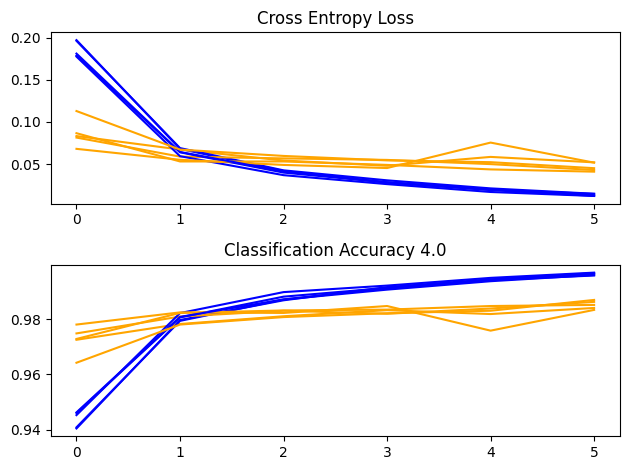

In [112]:
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY, testY_ = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# fit model                       
	# 
	# 
	#                    
	scores, histories = list(), list()
	# preparing cross validation
	kfold = KFold(5, shuffle=True, random_state=1)
	fold_counter = 1 
	es_callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
											mode="min",
											verbose=1,
											patience=4)
	# enumerate splits
	for train_ix, test_ix in kfold.split(trainX):
			
		print("*"*100)
		print("Fold-Nr.{}".format(fold_counter))
		print("-"*100, "\n")
		# print("-"*50, "\n")
		print("It's training time, but we won't forget the Validation :)")
		fold_counter += 1

		# define model
		model = define_model()
		trainXm, trainYm, testXm, testYm = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix]
		history = model.fit(trainXm, 
								trainYm, 
								epochs=6, 
								batch_size=16, 
								validation_data=(testX, testY), 
								callbacks=[es_callbacks] )
		# evaluate model
		print("-"*100)
		print("Let's go, Testing, Elevation!")
		acc = model.evaluate(testXm, testYm)
		# model scores
		scores.append(acc)
		histories.append(history)
		print("\n")
	print("workout finished")

	

	# model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
	# save model
	model.save('mnist_model1.h5')
	summarize_diagnostics(histories)
 
# entry point, run the test harness
run_test_harness()

As we can see, our model trains very well with an validation acurracy up to 0.985, which is no rocket science but an acceptable result. The test accuracy even achieves up to 0.989, while the loss was be reduced to 0.05. 
This is the point at which further layers can be implemented and or a variable learning rate could be used. This allows us to output the perfect learning rate and we would not have to keep trying. Due to time constraints, I have not implemented the idea in code.

### Adding Extensions
After we have created our base model, we would like to add extensions. To get a better understanding of the model and its decisions, its errors should be output visually. One idea was to detect the worst predicted digit by detecting the most ambiguous prediction. However, I implemented the idea of outputting all incorrectly predicted samples in the function and evaluating them based on their properties.  I decided it would be a better way to see not just the worst, but all false predicted digits of a choosen number of testsamples. The plot function is based on the function in the DeepDive (https://github.com/schutera/DeepDive/blob/main/TheseAreNotTheSolutionsYouAreLookingFor.ipynb).

In [113]:
def plot(model, testX, testY_, numbers_to_display):
    predictions = model.predict([testX])
    predictions = np.argmax(predictions, axis=1)
    num_cells = math.ceil(math.sqrt(numbers_to_display))
    plt.figure(figsize=(25, 25))
    false_counter = 0

    for plot_index in range(numbers_to_display):    
        predicted_label = predictions[plot_index]
        if predicted_label != testY_[plot_index]:
            color_map = 'Greens' if predicted_label == testY_[plot_index] else 'Reds'
            plt.subplot(num_cells, num_cells, false_counter + 1)
            plt.imshow(testX[plot_index].reshape((28, 28)), cmap=color_map)
            plt.xlabel(predicted_label)
            plt.tight_layout(pad=5.0) 
            plt.xticks([])
            plt.yticks([])
            plt.grid(True)
            false_counter += 1
    print("\nFalse digits: %d of %d" % (false_counter, numbers_to_display))
plt.subplots_adjust(hspace=5, wspace=1)
plt.show()

<Figure size 640x480 with 0 Axes>

> 98.840
313/313 [==============================] - 1s 4ms/step


C:\Users\ratti\AppData\Local\Temp\ipykernel_5024\3352835538.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(pad=5.0) # pad=5.0 kann z.B. eingefügt werdenHowever, I implemented the idea of outputting all incorrectly predicted samples in the function and evaluating them based on their properties
C:\Users\ratti\AppData\Local\Temp\ipykernel_5024\3352835538.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad=5.0) # pad=5.0 kann z.B. eingefügt werdenHowever, I implemented the idea of outputting all incorrectly predicted samples in the function and evaluating them based on their properties



False digits: 14 of 1000


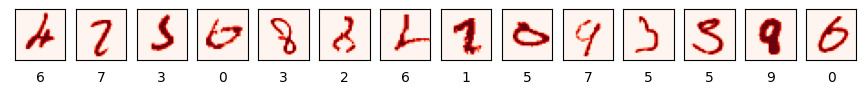

In [114]:
def run_test_harness():
 # load dataset
 trainX, trainY, testX, testY, testY_ = load_dataset()
 # prepare pixel data
 trainX, testX = prep_pixels(trainX, testX)
 # load model
 model = tf.keras.models.load_model('mnist_model.h5')
 # evaluate model on test dataset
 _, acc = model.evaluate(testX, testY, verbose=0)
 print('> %.3f' % (acc * 100.0))
 #plot images
 plot(model, testX, testY_, 1000)
 
# entry point, run the test harness
run_test_harness()

### Conclusion

So, let's take a look at the digits. It will be apparent that many of the false predicted digits are inaccuracies, such as sloppy spelling (ex. 1st digit '4', 9th digit '0'). It is very noticeable, that thickly written digits are difficult to recognize (13th digit '9').  The model also has a problem with digits that are not finished (e.g. 3rd digit '5'). 
I have assumed that the model will recognize numbers with circles ('6', '8', '9') significantly worse. However, this is not the case.

It can be said that the model is especially sensitive to sloppy spelling. A number correlation could not be established.

Thanks for reading and 

# Merry Christmas!